In [26]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from tqdm import tqdm
import os
import numpy as np
import matplotlib.pyplot as plt
from transformers import BartTokenizer

In [21]:
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
def bart_count_token(text):
    return len(tokenizer.encode(text, return_tensors="pt", add_special_tokens=True)[0])

In [22]:
bart_count_token("Hello, I'm a good boy!")

10

In [12]:
df_CNN = pd.read_csv("./dat/cnn_dailymail_test.csv")

In [13]:
for file_path in os.listdir('dat'):
    if not file_path.endswith('.csv') or not file_path.startswith('cnn_dailymail_test-'): continue
    print(file_path)

cnn_dailymail_test-(原始)compress-bart.csv
cnn_dailymail_test-highlighted-bart.csv
cnn_dailymail_test-abstracted-bart.csv
cnn_dailymail_test-summarized-bart.csv
cnn_dailymail_test-summarized.csv
cnn_dailymail_test-compressed.csv
cnn_dailymail_test-abstracted.csv
cnn_dailymail_test-token_count.csv
cnn_dailymail_test-compressed-bart.csv
cnn_dailymail_test-highlighted.csv


In [16]:
dataset = "cnn_dailymail_test" # 這是檔案名稱前面的 dataset
process_names = [
    "summarized",
    "summarized-bart",
    
    "compressed",
    "compressed-bart",
    
    "abstracted",
    "abstracted-bart",
    
    "highlighted", 
    "highlighted-bart",
    
    "(原始)compress-bart"
]

dfs = {}
for process_name in process_names:
    df = pd.read_csv(f"./dat/{dataset}-{process_name}.csv")
    dfs[process_name] = df
    #---
    print(f"{process_name:>18}:\t{', '.join(df.columns.tolist())} - {df.shape}")

        summarized:	id, article - (11490, 2)
   summarized-bart:	id, article - (11489, 2)
        compressed:	id, article - (11490, 2)
   compressed-bart:	id, article - (11490, 2)
        abstracted:	id, article - (11490, 2)
   abstracted-bart:	id, article - (11490, 2)
       highlighted:	id, article - (11490, 2)
  highlighted-bart:	id, article - (11490, 2)
 (原始)compress-bart:	id, article - (11490, 2)


In [17]:
cnn_ids = df_CNN['id'].tolist()
for process_name in dfs:
    df = dfs[process_name]
    for i in range(df.shape[0]):
        if not df['id'][i] in cnn_ids:
            df = df.iloc[i+1:]
    dfs[process_name] = df
    print(f"{process_name:>18}:\t{', '.join(df.columns.tolist())} - {df.shape}")

        summarized:	id, article - (11490, 2)
   summarized-bart:	id, article - (11489, 2)
        compressed:	id, article - (11490, 2)
   compressed-bart:	id, article - (11489, 2)
        abstracted:	id, article - (11490, 2)
   abstracted-bart:	id, article - (11489, 2)
       highlighted:	id, article - (11490, 2)
  highlighted-bart:	id, article - (11490, 2)
 (原始)compress-bart:	id, article - (11490, 2)


In [24]:
df_token_counts = {}
for process_name, df in dfs.items():
    total_len = df.shape[0]
    articles    = df['article'].tolist()
    token_counts = []
    for index in tqdm(range(total_len), desc=f"ROUGE-{process_name:<18}\t", total=total_len, bar_format='{l_bar}{bar:30}{r_bar}{bar:-10b}'):
        token_counts.append(bart_count_token(articles[index]))
    df_token_counts[process_name] = token_counts

ROUGE-(原始)compress-bart 	: 100%|██████████████████████████████| 11490/11490 [00:04<00:00, 2461.94it/s]                                              


In [29]:
df_CNN_token_count = pd.read_csv("./dat/cnn_dailymail_test-token_count.csv")

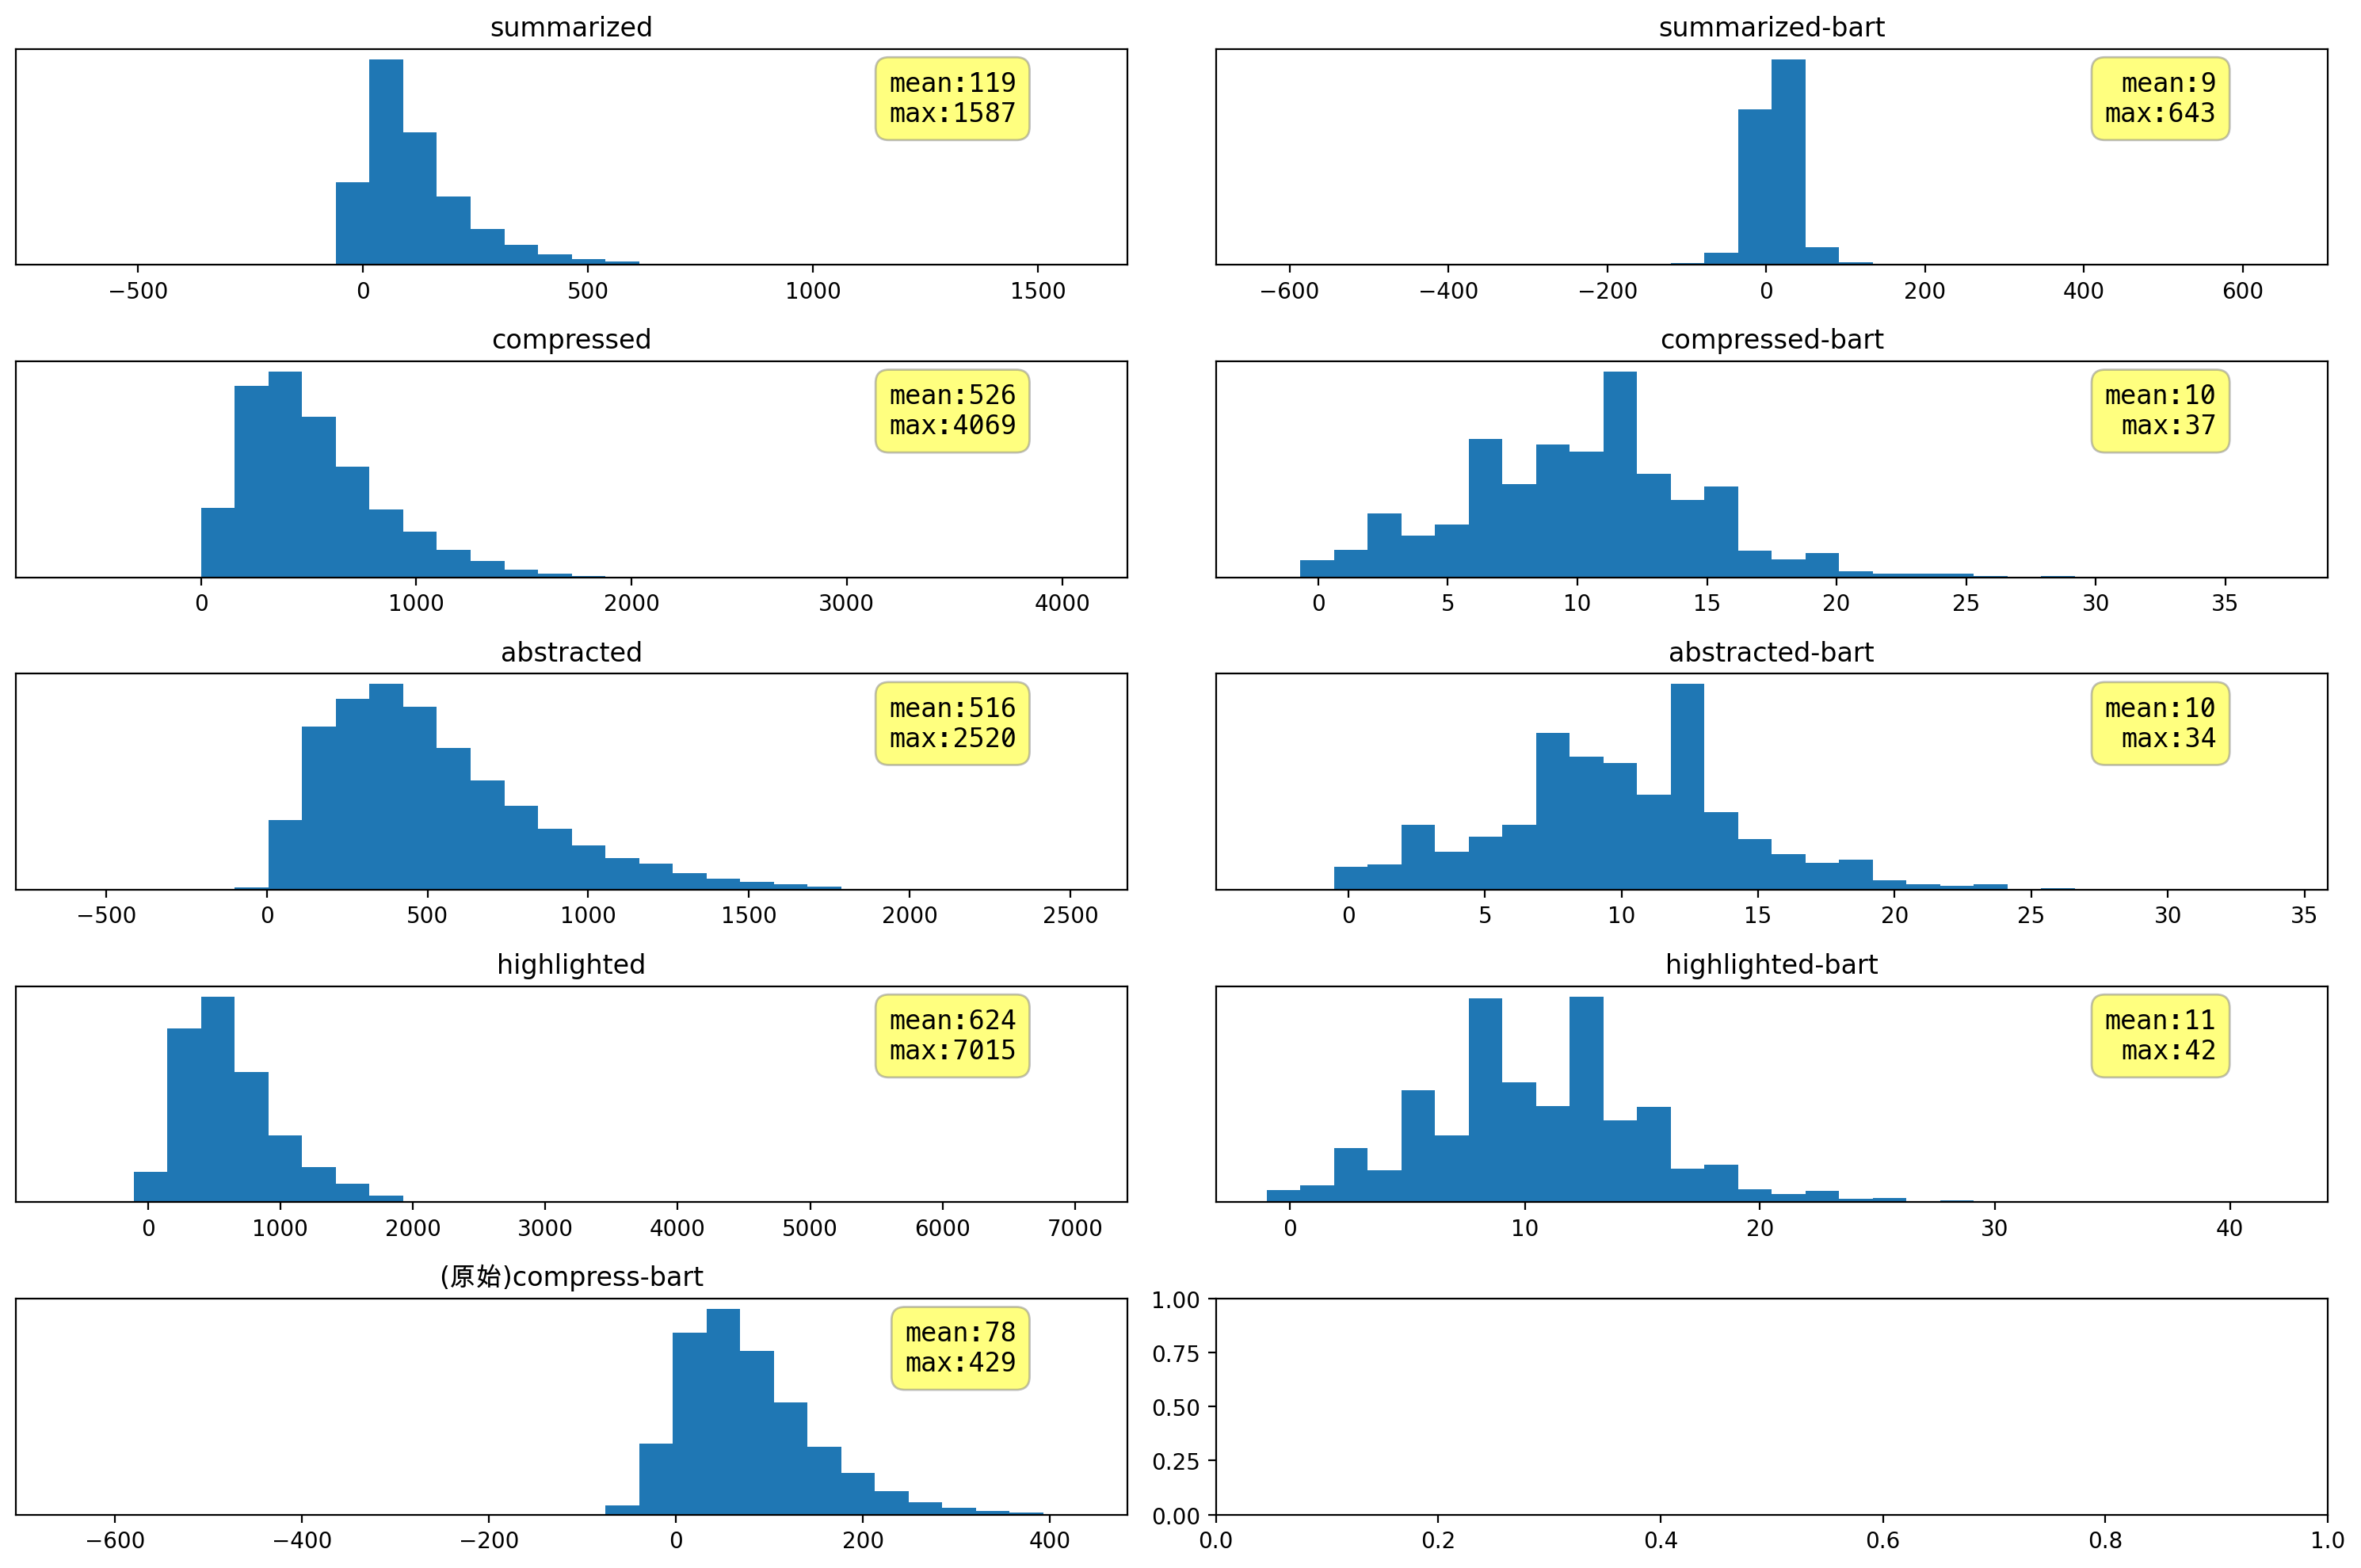

In [114]:
goal_token_count = df_CNN_token_count['highlights'].to_numpy()
row = 4
fig = plt.figure(dpi=200, figsize=(15,10))
axs = fig.subplots(5,2).flatten()

i = 0
for process_name, token_count in df_token_counts.items():
    token_count = np.array(token_count)
    length = len(token_count)
    diff = token_count - goal_token_count[-length:]
    mean = np.mean(diff)
    max = np.max(diff)
    axs[i].hist(diff,bins=30)
    axs[i].set_yticks([])
    axs[i].set_title(process_name, fontname=['DejaVu Sans', 'Arial Unicode Ms'])
    axs[i].text(0.9, 0.9, f'mean:{mean:0.0f}\nmax:{max}', fontsize=12, fontname='Menlo',
                transform=axs[i].transAxes, verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round,pad=0.5', fc='yellow', ec='0.5', alpha=0.5))
    i+=1
plt.tight_layout()
plt.show()

In [115]:
fig.savefig("./result/token-count-compare.pdf")